## 5. Prophetによる予測と評価

**概要:**
- 本ノートブックでは、Facebook社開発のProphetライブラリを用いて予測モデルを構築する。自動化された機能の有用性と、パラメータチューニングによる精度向上の可能性を検証する。

**Prophet選定の理由:**
Prophetは、一般化加法モデル（GAM）をベースとしており、以下の特長を持つ。
- **自動化と簡易性**: 複雑な時系列分析の知識がなくとも、トレンド、季節性、祝日効果などを自動で検出し、比較的容易に精度の高いモデルを構築できる。
- **解釈可能性**: モデルを「トレンド」「季節性」「祝日効果」などの成分に分解できるため、予測結果の根拠を理解しやすく、データの特性把握にも役立つ。
- **柔軟なカスタマイズ**: カスタムの季節性や祝日、外部変数を簡単に追加でき、ドメイン知識をモデルに反映させやすい。

これらの特長から、迅速なモデル構築と深いデータ理解の両面で有用であると判断し、採用した。

### 5-1. 準備：ライブラリ、データ、共通設定

In [1]:
# ライブラリのインポート
from pathlib import Path 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from tqdm.notebook import tqdm

# Prophet
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.diagnostics import cross_validation, performance_metrics

# レンダリングエラー対応
import plotly.io as pio
pio.renderers.default = "vscode" 

# Optuna関連
import optuna
from sklearn.metrics import mean_squared_error

# 共通モジュールのインポート
from src.data_utils import load_timeseries_data
from src.evaluation_utils import evaluate_forecast
from src.forecast_utils import sliding_window_forecast
from src.plot_utils import plot_forecast_vs_actual

# スタイル設定
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = [15, 6]
plt.rcParams['font.family'] = 'Meiryo' # Windowsの場合

# 警告を非表示
import warnings
warnings.filterwarnings('ignore')

In [2]:
# load data
BASE_DIR = Path().resolve()
DATA_DIR = BASE_DIR.parent / "data"
target_file = DATA_DIR / "e_gen_demand.csv"

df = load_timeseries_data(target_file)

print("データ形状:", df.shape)
print("データ期間:", df.index.min(), "から", df.index.max())
df.head()

データ形状: (39408, 2)
データ期間: 2023-01-01 00:00:00 から 2025-03-31 23:30:00


,solar_gen_mw,e_demand_mw
datetime,,
2023-01-01 00:00:00,0,29870
2023-01-01 00:30:00,0,28640
2023-01-01 01:00:00,0,27560
2023-01-01 01:30:00,0,27240
2023-01-01 02:00:00,0,26650


In [3]:
# 07_lightGBM.ipynb, 08_gru_forecast.ipynb の　yをshiftさせる手法との関係で
# 1日データを後ろに移行する
df = df[48:]
df.head()

,solar_gen_mw,e_demand_mw
datetime,,
2023-01-02 00:00:00,0,26500
2023-01-02 00:30:00,0,25590
2023-01-02 01:00:00,0,24850
2023-01-02 01:30:00,0,24460
2023-01-02 02:00:00,0,24430


**slidig_window 関数、評価関数の定義と共通設定**

時系列交差検証のために、スライディングウィンドウ関数 `src/forecast_utils.py sliding_window_forecast`、  
評価指標（MAE, RMSE, MASE）を計算する関数　`src/evaluation_utils.py evaluate_forecast`を使用する。

**MASEの季節性**:
    * 発電量 (solar\_gen\_mw) の季節周期 $m=48$（日周期）
    * 消費量 (e\_demand\_mw) の季節周期 $m=336$（週周期）

In [4]:
# スライディングウィンドウの共通パラメータ
TRAIN_LENGTH = 2880  # 60 days * 48 points/day
TEST_LENGTH = 48     # 1 day * 48 points/day
SLIDE_COUNT = 30     # 30 days
STRIDE = 48          # 1 day (non-overlapping)

In [5]:
# Prophetモデルのラッパー関数 
def prophet_model_wrapper(train_data, test_steps, **model_params):
    # Prophetはカラム名を 'ds' と 'y' にする必要がある
    prophet_df = train_data.reset_index()
    prophet_df.columns = ['ds', 'y']
    
    # モデルの定義と学習
    model = Prophet(**model_params)
    model.fit(prophet_df)
    
    # 予測用のデータフレームを作成
    future = model.make_future_dataframe(periods=test_steps, freq='30T')
    forecast = model.predict(future)
    
    # 予測期間の予測値とモデル、予測結果DFを返す
    return forecast['yhat'].values[-test_steps:], model, forecast

# 初期モデルパラメータ 
initial_model_params = {
    'daily_seasonality': True,
    'weekly_seasonality': True,
    'yearly_seasonality': True
}

### 5-2. デフォルト設定でのベースライン予測

#### 5-2-1. 予測の実行(発電・消費)

In [6]:
# 発電量と消費量の予測 
print("Prophet: 発電量の予測を開始...")
preds_df_gen, models_gen, _ = sliding_window_forecast(
    data=df,
    y_col='solar_gen_mw',
    train_length=TRAIN_LENGTH,
    test_length=TEST_LENGTH,
    slide_count=SLIDE_COUNT,
    stride=STRIDE,
    model_func=prophet_model_wrapper,
    model_params=initial_model_params
)
print("完了。")

print("Prophet: 消費量の予測を開始...")
preds_df_con, models_con, _ = sliding_window_forecast(
    data=df,
    y_col='e_demand_mw',
    train_length=TRAIN_LENGTH,
    test_length=TEST_LENGTH,
    slide_count=SLIDE_COUNT,
    stride=STRIDE,
    model_func=prophet_model_wrapper,
    model_params=initial_model_params
)
print("完了。")

Prophet: 発電量の予測を開始...


Sliding Window:   0%|          | 0/30 [00:00<?, ?it/s]

10:09:45 - cmdstanpy - INFO - Chain [1] start processing
10:09:45 - cmdstanpy - INFO - Chain [1] done processing
10:09:46 - cmdstanpy - INFO - Chain [1] start processing
10:09:46 - cmdstanpy - INFO - Chain [1] done processing
10:09:47 - cmdstanpy - INFO - Chain [1] start processing
10:09:47 - cmdstanpy - INFO - Chain [1] done processing
10:09:48 - cmdstanpy - INFO - Chain [1] start processing
10:09:48 - cmdstanpy - INFO - Chain [1] done processing
10:09:49 - cmdstanpy - INFO - Chain [1] start processing
10:09:49 - cmdstanpy - INFO - Chain [1] done processing
10:09:50 - cmdstanpy - INFO - Chain [1] start processing
10:09:50 - cmdstanpy - INFO - Chain [1] done processing
10:09:51 - cmdstanpy - INFO - Chain [1] start processing
10:09:51 - cmdstanpy - INFO - Chain [1] done processing
10:09:52 - cmdstanpy - INFO - Chain [1] start processing
10:09:53 - cmdstanpy - INFO - Chain [1] done processing
10:09:54 - cmdstanpy - INFO - Chain [1] start processing
10:09:55 - cmdstanpy - INFO - Chain [1]

完了。
Prophet: 消費量の予測を開始...


Sliding Window:   0%|          | 0/30 [00:00<?, ?it/s]

10:10:18 - cmdstanpy - INFO - Chain [1] start processing
10:10:19 - cmdstanpy - INFO - Chain [1] done processing
10:10:20 - cmdstanpy - INFO - Chain [1] start processing
10:10:21 - cmdstanpy - INFO - Chain [1] done processing
10:10:21 - cmdstanpy - INFO - Chain [1] start processing
10:10:22 - cmdstanpy - INFO - Chain [1] done processing
10:10:23 - cmdstanpy - INFO - Chain [1] start processing
10:10:23 - cmdstanpy - INFO - Chain [1] done processing
10:10:24 - cmdstanpy - INFO - Chain [1] start processing
10:10:25 - cmdstanpy - INFO - Chain [1] done processing
10:10:25 - cmdstanpy - INFO - Chain [1] start processing
10:10:26 - cmdstanpy - INFO - Chain [1] done processing
10:10:27 - cmdstanpy - INFO - Chain [1] start processing
10:10:27 - cmdstanpy - INFO - Chain [1] done processing
10:10:28 - cmdstanpy - INFO - Chain [1] start processing
10:10:29 - cmdstanpy - INFO - Chain [1] done processing
10:10:29 - cmdstanpy - INFO - Chain [1] start processing
10:10:30 - cmdstanpy - INFO - Chain [1]

完了。


#### 5-2-2. 評価と結果の可視化

In [7]:
# 評価結果の作成 
# MASE計算のため、最初の学習データを使用
y_train_gen = df['solar_gen_mw'].iloc[:TRAIN_LENGTH]
metrics_gen = evaluate_forecast(preds_df_gen['true'], preds_df_gen['pred'], y_train_gen.values, m=48)

y_train_con = df['e_demand_mw'].iloc[:TRAIN_LENGTH]
metrics_con = evaluate_forecast(preds_df_con['true'], preds_df_con['pred'], y_train_con.values, m=336)

# 評価結果の表示 
print("Prophet 評価結果 (30日間) ")
prophet_summary = pd.DataFrame({
    'generation': metrics_gen,
    'consumption': metrics_con
})
print(prophet_summary)

Prophet 評価結果 (30日間) 
       generation  consumption
MAE   1772.373970  2323.211371
RMSE  2436.543373  2888.244610
MASE     2.408882     0.735676


**評価結果（デフォルト）**
|      | generation  | consumption |
|------|------------:|------------:|
| MAE  | 1772.37 | 2323.21 |
| RMSE | 2436.54 | 2888.24 |
| MASE | 2.409 | 0.736 |

**考察:**
- **発電量予測**: MASEが2.41と大きく、Holt-Winters法（2.26）やSARIMAX（1.90）よりも精度が低い結果となった。デフォルト設定では、太陽光発電の持つ急峻な日内変動パターンを捉えきれていない。
- **消費量予測**: MASEが0.74と1を下回る値を示しているが、Holt-Winters法（0.53）やSARIMAX（0.54）といった他のベースラインモデルには及ばなかった。

デフォルト設定のままでは、Prophetは他のベースラインモデルを上回る性能を示せなかった。次工程では、Prophetの強みであるパラメータチューニングを行い、精度向上を目指す。

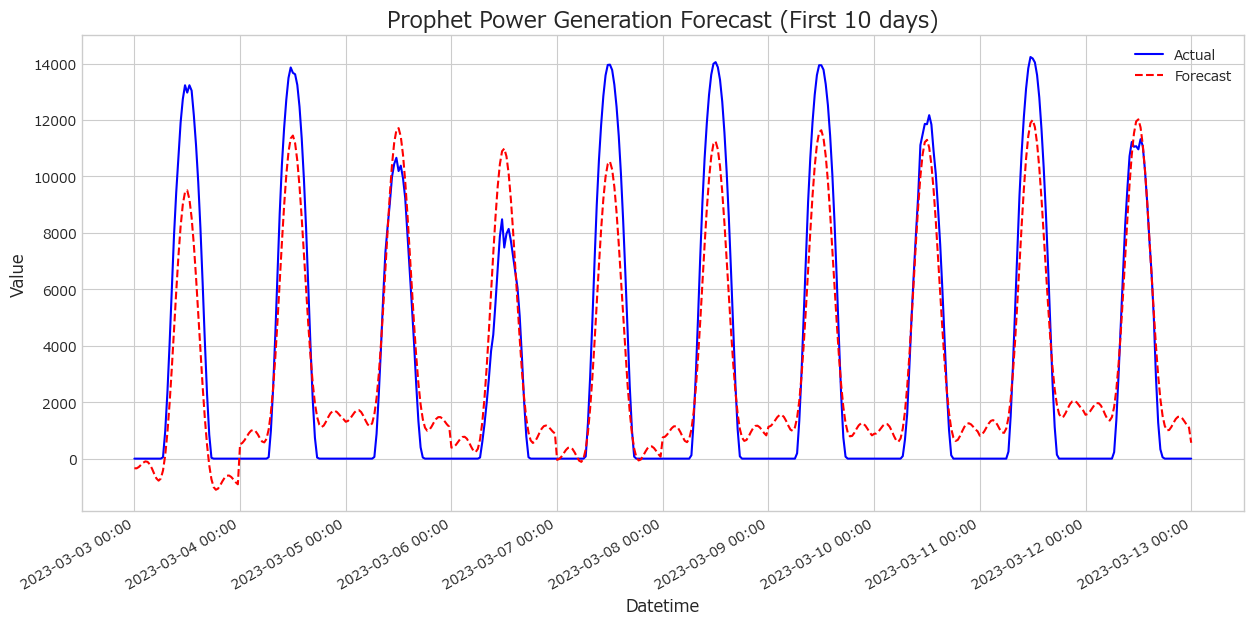

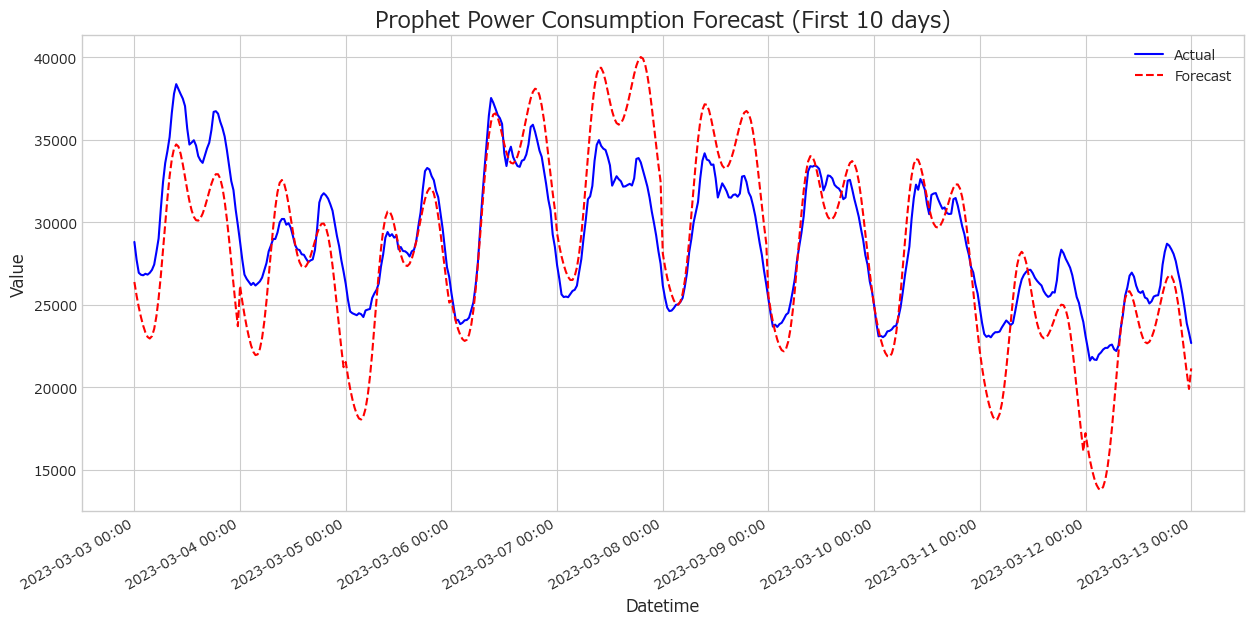

In [8]:
# 可視化の実行
# 発電
plot_forecast_vs_actual(preds_df_gen, 'Prophet Power Generation Forecast (First 10 days)', days_to_show=10)
# 消費
plot_forecast_vs_actual(preds_df_con, 'Prophet Power Consumption Forecast (First 10 days)', days_to_show=10)

#### 5-2-3. 成分分解によるモデル解釈

prophet の plot_components を用いてトレンド、周期性、残差の成分分解を表示し、データへの理解を深める。

観察、理解のため全期間を使用するが、リーク防止のため、ここから数値を取得し他へ使用をすることは控える。

In [9]:
# 長期間の成分分解のため、新たに全期間のpropeht用df を作成
df_prophet = df.copy()

df_gen = df_prophet['solar_gen_mw'].reset_index()
df_gen.columns = ['ds', 'y']

df_con = df_prophet['e_demand_mw'].reset_index()
df_con.columns = ['ds', 'y']

10:10:59 - cmdstanpy - INFO - Chain [1] start processing
10:11:09 - cmdstanpy - INFO - Chain [1] done processing


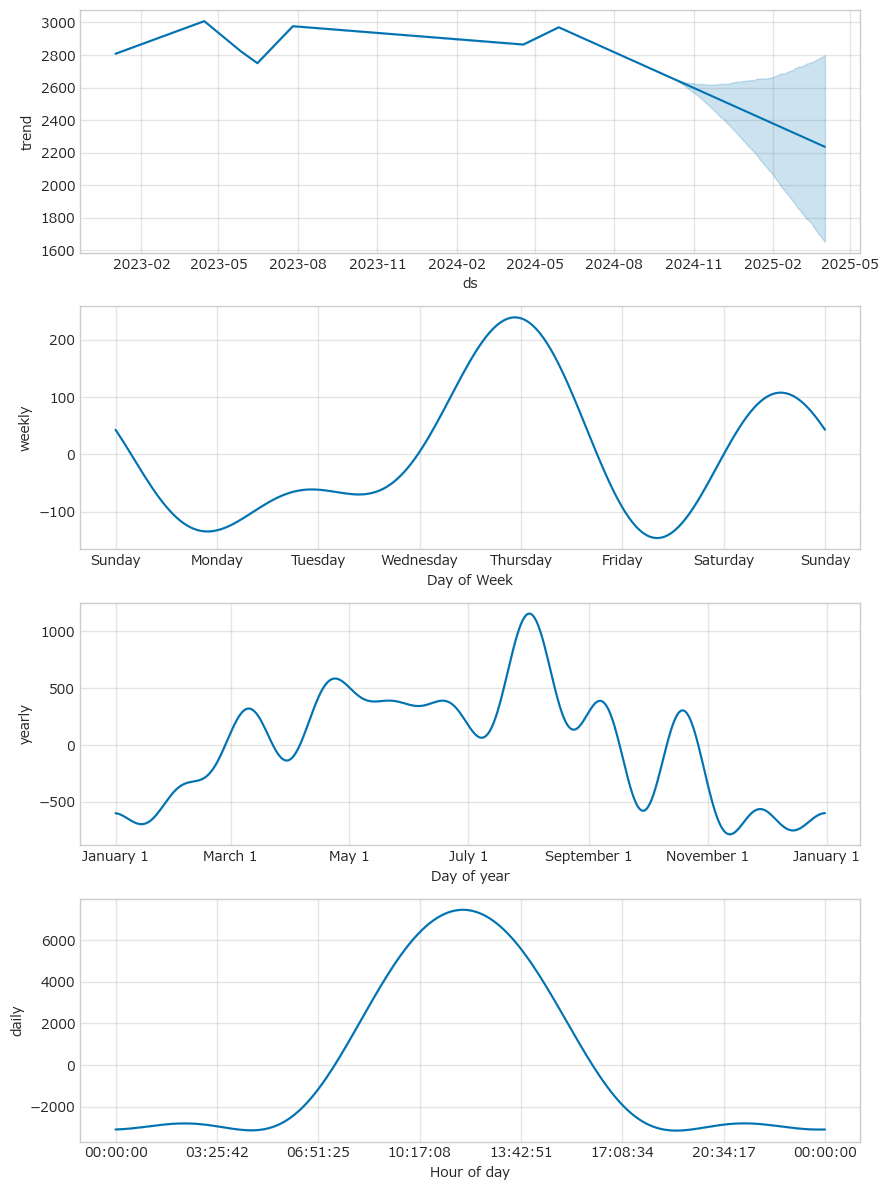

In [10]:
# 発電　成分分解
# 期間設定
points_per_day = 48
forecast_length = int(48 * 180 ) # 約半年
train_length = int(39408 - forecast_length)   # 30768 約21ヶ月

# データから切り出し
df_recent = df_gen[0:train_length]

# Prophet モデル
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=True,   
)
model.fit(df_recent)

# 未来半年を予測
future = model.make_future_dataframe(periods=forecast_length, freq='30min')
forecast = model.predict(future)

# 成分分解グラフ表示
fig = model.plot_components(forecast)
plt.show()

10:11:16 - cmdstanpy - INFO - Chain [1] start processing
10:11:39 - cmdstanpy - INFO - Chain [1] done processing


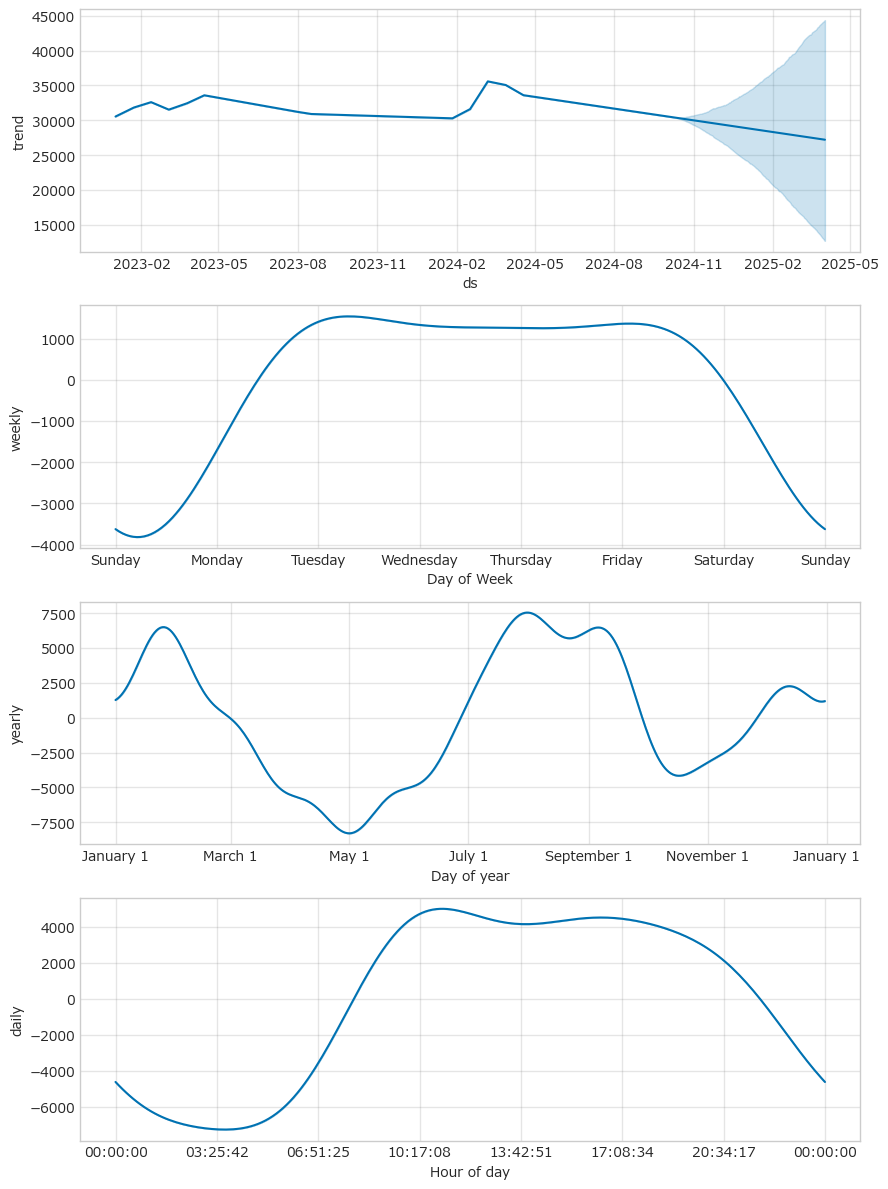

In [11]:
# 需要　成分分解

# データ切り出し
df_recent = df_con[0:train_length]

# Prophet モデル
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=True,   
)
model.fit(df_recent)

# 未来半年を予測
future = model.make_future_dataframe(periods=forecast_length, freq='30min')
forecast = model.predict(future)

# 成分分解グラフ表示
fig = model.plot_components(forecast)
plt.show()

**考察**
- 03_Hierarchical_Pattern_Analysis_and_Data_Insight 前半の 年次、週次、日次の変化とほぼ同様の結果となった。
- 発電は週次（曜日別）変動は幅が小さく、年次（月別）は夏高くまた6月など梅雨時期若干上昇が鈍り、日次はほぼ太陽光の量と考えられる。
- 需要（消費）は年次は夏と冬が高い冷暖房需要、週次は月曜やや鈍く立ち上がり平日高く週末へ低下、日次は朝から急に立ち上がり昼から午後高原状、夜間は深夜にかけ低下している。
- 両方とも人間が推測するパターンと一致し、納得性は高いが、月別平均などでは1つの数値になってしまうのに対し、この分解では月初から月末への変化も読み取れる。

### 5-3. Optunaによるハイパーパラメータ最適化

- Prophetの予測精度は、パラメータ設定に大きく依存する。ここでは、特に季節性の柔軟性を制御する`seasonality_prior_scale`と、トレンドの変動点の柔軟性を制御する`changepoint_prior_scale`の2つの重要パラメータを中心にチューニングを行う。

### 5-3-1. 発電量予測のチューニング

In [12]:
# Optunaの目的関数を定義
# チューニング対象のデータを固定 (最初の60日間 = TRAIN_LENGTH)
tune_df_gen = df[['solar_gen_mw']].iloc[:TRAIN_LENGTH].reset_index()
tune_df_gen.columns = ['ds', 'y']

def objective_gen(trial):
    # チューニングするパラメータの範囲を定義
    params = {
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 0.5, log=True),
        'seasonality_prior_scale': trial.suggest_float('seasonality_prior_scale', 0.01, 10, log=True),
        'daily_seasonality': True,
        'weekly_seasonality': True,
        'yearly_seasonality': True
    }
    
    # モデルの定義
    model = Prophet(**params)
    model.fit(tune_df_gen)
    
    # TRAIN_LENGTH内でクロスバリデーションを実行
    # initial: 48日, period: 1日, horizon: 1日
    # これにより、48日から12回の検証が行われる
    df_cv = cross_validation(
        model,
        initial='48 days', # 48日
        period='1 day',  # 1日
        horizon='1 day', # 1日
        disable_tqdm=True # tqdmの出力を抑制
    )
    
    # 評価 (RMSE)
    df_p = performance_metrics(df_cv)
    
    return df_p['rmse'].values[0]

# Optunaによる最適化の実行
print("Optunaによるハイパーパラメータチューニングを開始します (発電量)...")
optuna.logging.set_verbosity(optuna.logging.WARNING) # Optunaのログ出力を抑制
study_gen = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))
study_gen.optimize(objective_gen, n_trials=30, show_progress_bar=False)

# 結果の表示
print("\nOptuna チューニング結果 (発電量)")
print(f"試行回数: {len(study_gen.trials)}")
print(f"最適パラメータ: {study_gen.best_params}")
print(f"最小RMSE: {study_gen.best_value}")

# 後続のセルで使うために best_params を保持
best_params_gen = study_gen.best_params

Optunaによるハイパーパラメータチューニングを開始します (発電量)...


10:11:44 - cmdstanpy - INFO - Chain [1] start processing
10:11:44 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
10:11:45 - cmdstanpy - INFO - Chain [1] start processing
10:11:45 - cmdstanpy - INFO - Chain [1] done processing
10:11:45 - cmdstanpy - INFO - Chain [1] start processing
10:11:45 - cmdstanpy - INFO - Chain [1] done processing
10:11:45 - cmdstanpy - INFO - Chain [1] start processing
10:11:46 - cmdstanpy - INFO - Chain [1] done processing
10:11:46 - cmdstanpy - INFO - Chain [1] start processing
10:11:46 - cmdstanpy - INFO - Chain [1] done processing
10:11:46 - cmdstanpy - INFO - Chain [1] start processing
10:11:46 - cmdstanpy - INFO - Chain [1] done processing
10:11:47 - cmdstanpy - INFO - Chain [1] start processing
10:11:47 - cmdstanpy - INFO - Chain [1] done processing
10:11:47 - cmdstanpy - INFO - Chain [1] start processing
10:11:47 - cmdstanpy - INFO - Chain [1] done pro


Optuna チューニング結果 (発電量)
試行回数: 30
最適パラメータ: {'changepoint_prior_scale': 0.03519174873408796, 'seasonality_prior_scale': 2.9081465894110603}
最小RMSE: 851.8145565809785


#### 5-3-2. チューニング後モデルによる発電量予測と評価

Optunaでチューニングしたパラメータを使い、発電量の30日間予測を再実行します...


Sliding Window:   0%|          | 0/30 [00:00<?, ?it/s]

10:15:02 - cmdstanpy - INFO - Chain [1] start processing
10:15:02 - cmdstanpy - INFO - Chain [1] done processing
10:15:03 - cmdstanpy - INFO - Chain [1] start processing
10:15:03 - cmdstanpy - INFO - Chain [1] done processing
10:15:04 - cmdstanpy - INFO - Chain [1] start processing
10:15:04 - cmdstanpy - INFO - Chain [1] done processing
10:15:05 - cmdstanpy - INFO - Chain [1] start processing
10:15:05 - cmdstanpy - INFO - Chain [1] done processing
10:15:05 - cmdstanpy - INFO - Chain [1] start processing
10:15:05 - cmdstanpy - INFO - Chain [1] done processing
10:15:06 - cmdstanpy - INFO - Chain [1] start processing
10:15:06 - cmdstanpy - INFO - Chain [1] done processing
10:15:07 - cmdstanpy - INFO - Chain [1] start processing
10:15:07 - cmdstanpy - INFO - Chain [1] done processing
10:15:08 - cmdstanpy - INFO - Chain [1] start processing
10:15:08 - cmdstanpy - INFO - Chain [1] done processing
10:15:09 - cmdstanpy - INFO - Chain [1] start processing
10:15:09 - cmdstanpy - INFO - Chain [1]

完了。
評価指標の比較 (発電量予測 - 30日間)
          Initial        Tuned
MAE   1772.373970  1730.195857
RMSE  2436.543373  2446.802209
MASE     2.408882     2.351556


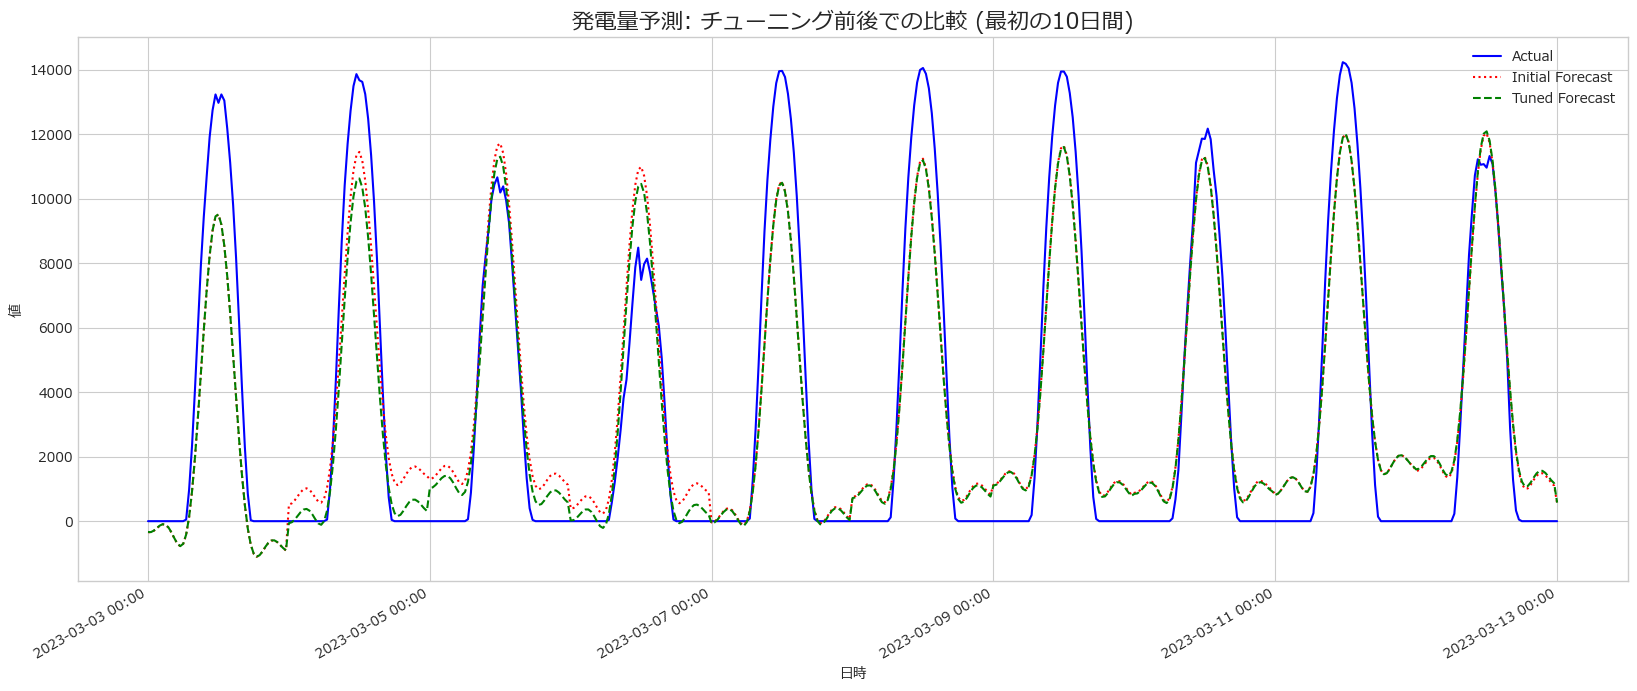

In [13]:
# 最適パラメータで30日間のスライディングウィンドウ予測を実行
print("Optunaでチューニングしたパラメータを使い、発電量の30日間予測を再実行します...")
tuned_model_params = {
    'daily_seasonality': True,
    'weekly_seasonality': True,
    'yearly_seasonality': True,
    **best_params_gen
}

# チューニング後のパラメータで消費量を再予測
preds_df_gen_tuned, _, _ = sliding_window_forecast(
    data=df,
    y_col='solar_gen_mw',
    train_length=TRAIN_LENGTH,
    test_length=TEST_LENGTH,
    slide_count=SLIDE_COUNT,
    stride=STRIDE,
    model_func=prophet_model_wrapper,
    model_params=tuned_model_params
)
print("完了。")

# 評価指標の比較 (30日間全体) 
y_train_gen = df['solar_gen_mw'].iloc[:TRAIN_LENGTH]
metrics_gen_tuned = evaluate_forecast(preds_df_gen_tuned['true'], preds_df_gen_tuned['pred'], y_train_gen.values, m=48)

print("評価指標の比較 (発電量予測 - 30日間)")
comparison_gen_df = pd.DataFrame({
    'Initial': metrics_gen,
    'Tuned': metrics_gen_tuned
})
print(comparison_gen_df)

# 可視化のための関数定義
# src.plot_utils plot_forecast_vs_actual から改変し、原系列、チューニング前、チューニング後を表示
def plot_tuned_forecast(initial_df, tuned_df, title, days_to_show=10):
    plt.figure(figsize=(20, 8))
    
    # 表示する期間を決定
    start_date = initial_df.index.min()
    end_date = start_date + pd.Timedelta(days=days_to_show)
    
    plot_data_initial = initial_df.loc[start_date:end_date]
    plot_data_tuned = tuned_df.loc[start_date:end_date]

    # 実測値のプロット
    plt.plot(plot_data_initial.index, plot_data_initial['true'], label='Actual', color='blue')

    # チューニング前の予測値をプロット
    plt.plot(plot_data_initial.index, plot_data_initial['pred'], color='red', linestyle=':', label='Initial Forecast')

    # チューニング後の予測値をプロット
    plt.plot(plot_data_tuned.index, plot_data_tuned['pred'], color='green', linestyle='--', label='Tuned Forecast')

    plt.title(title, fontsize=16)
    plt.xlabel('日時')
    plt.ylabel('値')
    plt.legend()
    plt.grid(True)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    plt.gcf().autofmt_xdate()
    plt.show()

# 可視化の実行 (最初の10日間)
plot_tuned_forecast(preds_df_gen, preds_df_gen_tuned, '発電量予測: チューニング前後での比較 (最初の10日間)', days_to_show=10)

**比較表**
```
評価指標の比較 (発電量予測 - 30日間)
          Initial        Tuned
MAE   1772.373970  1730.195857
RMSE  2436.543373  2446.802209
MASE     2.408882     2.351556
```

### 5-3-3. 消費量予測のチューニング

In [14]:
# Optunaの目的関数を定義
# チューニング対象のデータを固定 (最初の60日間 = TRAIN_LENGTH)
tune_df_con = df[['e_demand_mw']].iloc[:TRAIN_LENGTH].reset_index()
tune_df_con.columns = ['ds', 'y']

def objective_con(trial):
    # チューニングするパラメータの範囲を定義
    params = {
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 0.5, log=True),
        'seasonality_prior_scale': trial.suggest_float('seasonality_prior_scale', 0.01, 10, log=True),
        'daily_seasonality': True,
        'weekly_seasonality': True,
        'yearly_seasonality': True
    }
    
    # モデルの定義
    model = Prophet(**params)
    model.fit(tune_df_con)
    
    # TRAIN_LENGTH内でクロスバリデーションを実行
    df_cv = cross_validation(
        model,
        initial='48 days', # 48日
        period=f'1 day',  # 1日
        horizon=f'1 day', # 1日
        disable_tqdm=True
    )
    
    # 評価 (RMSE)
    df_p = performance_metrics(df_cv)
    
    return df_p['rmse'].values[0]

# Optunaによる最適化の実行
print("Optunaによるハイパーパラメータチューニングを開始します (消費量)...")
optuna.logging.set_verbosity(optuna.logging.WARNING)
study_con = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))
study_con.optimize(objective_con, n_trials=30, show_progress_bar=False)

# 結果の表示
print("\nOptuna チューニング結果 (消費量)")
print(f"試行回数: {len(study_con.trials)}")
print(f"最適パラメータ: {study_con.best_params}")
print(f"最小RMSE: {study_con.best_value}")

# 後続のセルで使うために best_params を保持
best_params_con = study_con.best_params

Optunaによるハイパーパラメータチューニングを開始します (消費量)...


10:15:27 - cmdstanpy - INFO - Chain [1] start processing
10:15:27 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
10:15:27 - cmdstanpy - INFO - Chain [1] start processing
10:15:28 - cmdstanpy - INFO - Chain [1] done processing
10:15:28 - cmdstanpy - INFO - Chain [1] start processing
10:15:28 - cmdstanpy - INFO - Chain [1] done processing
10:15:28 - cmdstanpy - INFO - Chain [1] start processing
10:15:29 - cmdstanpy - INFO - Chain [1] done processing
10:15:29 - cmdstanpy - INFO - Chain [1] start processing
10:15:29 - cmdstanpy - INFO - Chain [1] done processing
10:15:29 - cmdstanpy - INFO - Chain [1] start processing
10:15:30 - cmdstanpy - INFO - Chain [1] done processing
10:15:30 - cmdstanpy - INFO - Chain [1] start processing
10:15:30 - cmdstanpy - INFO - Chain [1] done processing
10:15:31 - cmdstanpy - INFO - Chain [1] start processing
10:15:31 - cmdstanpy - INFO - Chain [1] done pro


Optuna チューニング結果 (消費量)
試行回数: 30
最適パラメータ: {'changepoint_prior_scale': 0.2922711681339094, 'seasonality_prior_scale': 0.45714120348138376}
最小RMSE: 2107.5020084468024


#### 5-3-4. チューニング後モデルによる消費量予測と評価

Optunaでチューニングしたパラメータを使い、消費量の30日間予測を再実行します...


Sliding Window:   0%|          | 0/30 [00:00<?, ?it/s]

10:24:02 - cmdstanpy - INFO - Chain [1] start processing
10:24:05 - cmdstanpy - INFO - Chain [1] done processing
10:24:05 - cmdstanpy - INFO - Chain [1] start processing
10:24:07 - cmdstanpy - INFO - Chain [1] done processing
10:24:08 - cmdstanpy - INFO - Chain [1] start processing
10:24:10 - cmdstanpy - INFO - Chain [1] done processing
10:24:10 - cmdstanpy - INFO - Chain [1] start processing
10:24:13 - cmdstanpy - INFO - Chain [1] done processing
10:24:13 - cmdstanpy - INFO - Chain [1] start processing
10:24:16 - cmdstanpy - INFO - Chain [1] done processing
10:24:17 - cmdstanpy - INFO - Chain [1] start processing
10:24:19 - cmdstanpy - INFO - Chain [1] done processing
10:24:19 - cmdstanpy - INFO - Chain [1] start processing
10:24:22 - cmdstanpy - INFO - Chain [1] done processing
10:24:23 - cmdstanpy - INFO - Chain [1] start processing
10:24:26 - cmdstanpy - INFO - Chain [1] done processing
10:24:26 - cmdstanpy - INFO - Chain [1] start processing
10:24:28 - cmdstanpy - INFO - Chain [1]

完了。
評価指標の比較 (消費量予測 - 30日間)
          Initial        Tuned
MAE   2323.211371  2163.355933
RMSE  2888.244610  2753.314147
MASE     0.735676     0.685055


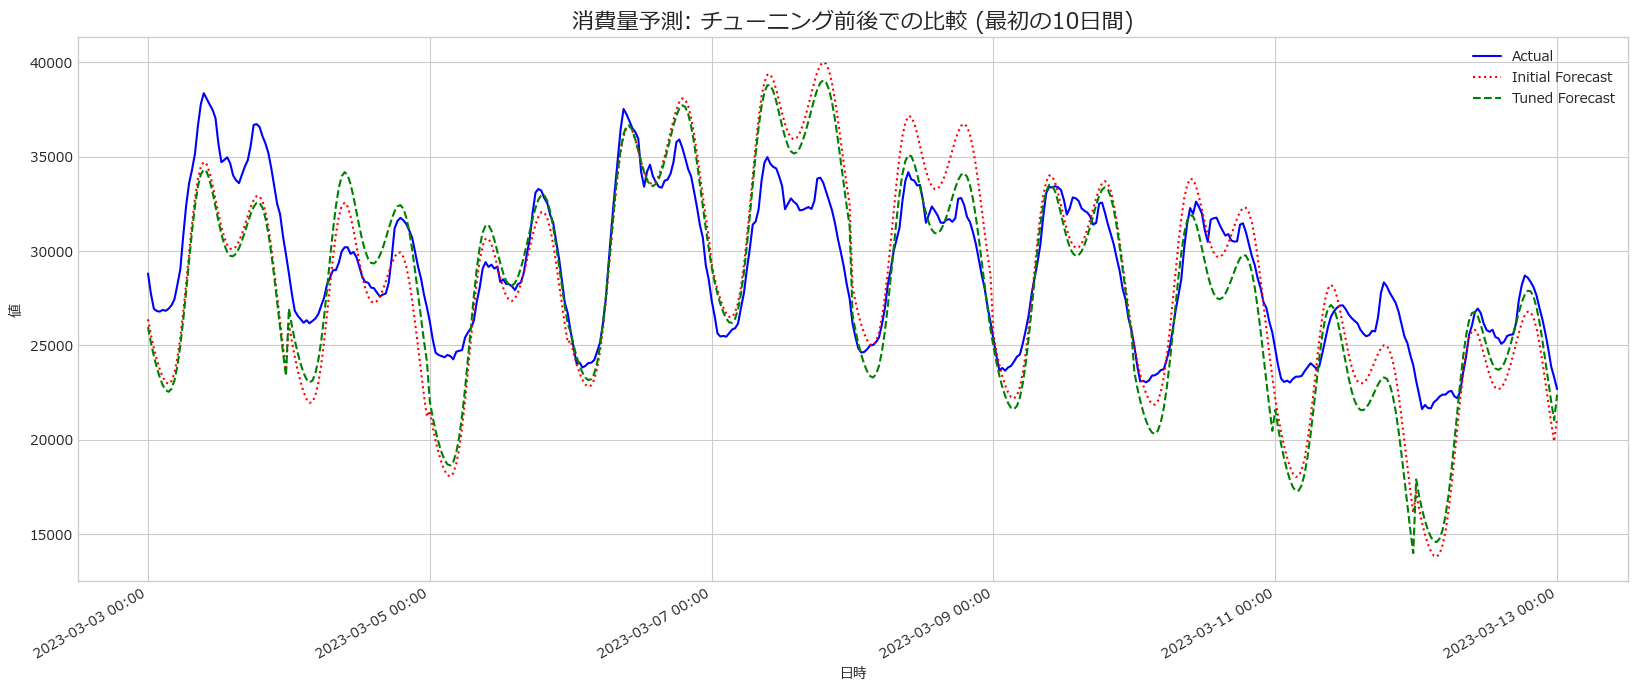

In [15]:
# 最適パラメータで30日間のスライディングウィンドウ予測を実行
print("Optunaでチューニングしたパラメータを使い、消費量の30日間予測を再実行します...")
tuned_model_params = {
    'daily_seasonality': True,
    'weekly_seasonality': True,
    'yearly_seasonality': True,
    **best_params_con
}

# チューニング後のパラメータで消費量を再予測
preds_df_con_tuned, _, _ = sliding_window_forecast(
    data=df,
    y_col='e_demand_mw',
    train_length=TRAIN_LENGTH,
    test_length=TEST_LENGTH,
    slide_count=SLIDE_COUNT,
    stride=STRIDE,
    model_func=prophet_model_wrapper,
    model_params=tuned_model_params
)
print("完了。")

# 評価指標の比較 (30日間全体)
y_train_con = df['e_demand_mw'].iloc[:TRAIN_LENGTH]
metrics_con_tuned = evaluate_forecast(preds_df_con_tuned['true'], preds_df_con_tuned['pred'], y_train_con.values, m=336)

print("評価指標の比較 (消費量予測 - 30日間)")
comparison_demand_df = pd.DataFrame({
    'Initial': metrics_con,
    'Tuned': metrics_con_tuned
})
print(comparison_demand_df)

# 可視化のための関数定義
def plot_tuned_forecast(initial_df, tuned_df, title, days_to_show=10):
    plt.figure(figsize=(20, 8))
    
    # 表示する期間を決定
    start_date = initial_df.index.min()
    end_date = start_date + pd.Timedelta(days=days_to_show)
    
    plot_data_initial = initial_df.loc[start_date:end_date]
    plot_data_tuned = tuned_df.loc[start_date:end_date]

    # 実測値のプロット
    plt.plot(plot_data_initial.index, plot_data_initial['true'], label='Actual', color='blue')

    # チューニング前の予測値をプロット
    plt.plot(plot_data_initial.index, plot_data_initial['pred'], color='red', linestyle=':', label='Initial Forecast')

    # チューニング後の予測値をプロット
    plt.plot(plot_data_tuned.index, plot_data_tuned['pred'], color='green', linestyle='--', label='Tuned Forecast')

    plt.title(title, fontsize=16)
    plt.xlabel('日時')
    plt.ylabel('値')
    plt.legend()
    plt.grid(True)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    plt.gcf().autofmt_xdate()
    plt.show()

# 可視化の実行 (最初の10日間)
plot_tuned_forecast(preds_df_con, preds_df_con_tuned, '消費量予測: チューニング前後での比較 (最初の10日間)', days_to_show=10)

**比較表**
```
評価指標の比較 (消費量予測 - 30日間)
          Initial        Tuned
MAE   2323.211371  2163.355933
RMSE  2888.244610  2753.314147
MASE     0.735676     0.685055
```

In [16]:
# 結果の保存
# pred_df には 'true', 'pred' カラムと datetime index がある前提

# solar_gen_mw
preds_df_gen_tuned.to_pickle('../results/preds/solar_prophet.pkl')
print("Saved: ")

# e_demand_mw
preds_df_con_tuned.to_pickle('../results/preds/demand_prophet.pkl')
print("Saved: ")

Saved: 
Saved: 


### 5-4. 結論と考察

### 5-5-1. 精度比較サマリー
| 評価指標 | **発電量** |  | **消費量** |  |
| :--- | :---: | :---: | :---: | :---: |
| | Initial |  Tuned |  Initial  |  Tuned |
| MAE| 1772.37 | 1730.20 | 2323.21 | 2163.36 |
| RMSE | 2436.54 | 2446.80 | 2888.24 | 2753.31 |
| MASE| 2.409 |  2.352 |  0.736 |  0.685 |

### 5-5-2. 総括
- **全体傾向**: パラメータチューニングにより、発電量・消費量ともに僅かな精度向上は見られたものの、その改善幅は限定的であった。Holt-Winters法やSARIMAXモデルの精度を上回ることはできなかった。
- **モデル選択に関する知見**:
    - Prophetはパラメータ設定が直感的で、季節性やトレンドの調整を容易に行える点が大きな長所である。特に、成分分解プロットはデータの構造理解に非常に有用であった。
    - しかし、今回のタスクにおいては、他のベースラインモデルと比較して精度面での優位性は見られなかった。これは、Prophetがデフォルトで想定する季節性パターン（フーリエ級数）が、電力データの持つ複雑な変動を完全に捉えきれなかった可能性を示唆している。
    - 太陽光発電のように特定の時間帯（日中）にのみ値を持つといった不規則性の強いデータに対しては、よりドメイン知識に基づいたカスタマイズ（上限・下限の設定、カスタム季節性の追加など）が必要であると考えられる。

**今後の展望:**
- Prophetは迅速な分析と解釈性に優れるため、初期の探索的モデリングには適している。しかし、予測精度を追求する上では、LightGBMなどの機械学習モデルに、Prophetの成分分解で得られた知見（トレンド、季節性など）を特徴量として加えるアプローチが有効であると推察される。
- prophet 自体の改良、精度向上策では、パラメータチューニングの候補となりうるものを一覧で表にまとめ、太陽光発電の夜間ゼロに対する対策案をその下に記載した。

**将来展望：参考情報**
tuning できるパラメーター　

今回主要な2つをtuning の対象としたが、
'changepoint_prior_scale'　トレンドの柔軟性を表す。
'seasonality_prior_scale'　季節成分の柔軟性を表す。

それ以外にも以下のように多数ある。上から概ね使用頻度が高い順

| パラメータ名                                                        | 対象                        | 典型的な範囲・値                                    | 概要・役割                                                |
|---------------------------------------------------------- |---------------------- |---------------------------------------- |------------------------------------------------- |
| **changepoint_prior_scale**                                   | トレンド変化（スロープ）              | 0.001 ～ 0.5（デフォルト 0.05）                     | トレンドの柔軟性を決める最重要パラメータ。小さいと滑らか・保守的、大きいと鋭く変化。過学習のリスクも。  |
| **seasonality_prior_scale**                                   | 季節性（全体）                   | 1 ～ 20（デフォルト 10）                            | 季節性成分の振れ幅をどの程度許すか。過小だと周期パターンを過度に抑える。                 |
| **holidays_prior_scale**                                      | 祝日効果                      | 0.01 ～ 10（デフォルト 10）                         | 祝日（または任意イベント）の影響強度。強くするとイベントに大きく反応。                  |
| **seasonality_mode**                                          | 季節性の形状                    | `'additive'` or `'multiplicative'`          | 季節性を加算型か乗算型で扱う。トレンドが増加する系列では `'multiplicative'` が有利。 |
| **changepoint_range**                                         | トレンド変化点の探索範囲              | 0.8 ～ 1.0（デフォルト 0.8）                        | トレンド変化点を学習期間のどこまで考慮するか。小さいと初期のみに限定。                  |
| **yearly_seasonality**                                        | 年間季節性                     | True / False / int                          | 自動検出または明示指定（例：10 → 10個のFourier項）。年単位の周期（例：売上、気温など）。  |
| **weekly_seasonality**                                        | 週間季節性                     | True / False / int                          | 週単位の周期を持つデータ（例：消費電力、交通量）。                            |
| **daily_seasonality**                                         | 日内季節性                     | True / False / int                          | 日単位の周期（例：時間別データ）。日次データでは基本False。                     |
| **fourier_order**（yearly/weekly/daily_seasonality に付随）        | 各季節性の分解精度                 | 3 ～ 20（デフォルト：yearly=10, weekly=3, daily=10） | 周期性を正弦波で表現する際の次数。多いほど細かい波形を表現。                       |
| **holidays**                                                  | DataFrame（date, holiday列） | 任意                                          | 特定日イベント（例：年末、休日）を外生効果としてモデル化。                        |
| **growth**                                                    | トレンド形式                    | `'linear'` / `'logistic'`                   | 線形またはロジスティック成長。容量上限(cap)設定が必要な場合は logistic。          |
| **cap / floor**                                               | トレンド上下限                   | 実データに応じて指定                                  | `growth='logistic'` の場合のみ使用。上限成長などを再現可能。             |
| **n_changepoints**                                            | トレンド変化点の候補数               | 10 ～ 50（デフォルト25）                            | 多いほど柔軟だが、過学習リスク増。                                    |
| **interval_width**                                            | 予測区間の幅                    | 0.8 ～ 0.95（デフォルト0.8）                        | 信頼区間の信頼度。評価指標算出時に重要。                                 |
| **mcmc_samples**                                              | ベイズ推定サンプル数                | 0 or 数値（例：100～500）                          | 不確実性評価用。0ならMAP推定のみ。計算コスト増大注意。                        |
| **uncertainty_samples**                                       | 予測区間のサンプル数                | 1000程度                                      | `predict()` 時の信頼区間精度。                                |
| **add_seasonality(name, period, fourier_order, prior_scale)** | カスタム季節性                   | 例：period=365.25/4, fourier_order=5          | 四半期・2年周期などを任意に追加できる柔軟設定。                             |
| **add_regressor(name, prior_scale, standardize)**             | 外生変数                      | 任意                                          | 気温や経済指標などを説明変数として追加。LASSOに似たスケーリング制御あり。              |

seasonality についての設定例　公式github より

```python
# Python
m = Prophet(weekly_seasonality=False)
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
forecast = m.fit(df).predict(future)
fig = m.plot_components(forecast)
```

**将来展望：太陽光発電の改善案**

* 日没後、日の出前の夜間が発電量ゼロ　これへの追随が悪い。

1. df 自体を制限してモデルに入れ、予測値は除外した時間をゼロにして戻す。  
    (年間の細かい動き、日の出日の入り時間の変化等は平均化で拾えなくなる)　

    ```python
    df_day = df[(df['ds'].dt.hour >= 5) & (df['ds'].dt.hour <= 18)]

    forecast = m.predict(future)
    forecast.loc[forecast['ds'].dt.hour < 5, 'yhat'] = 0
    forecast.loc[forecast['ds'].dt.hour > 18, 'yhat'] = 0
    ```

2. 同じ発想だが、日が出ている時間を外生変数に加える。  
    (年間の細かい動き、日の出日の入り時間の変化等は平均化で拾えなくなる)

    ```python
    df['daylight'] = ((df['ds'].dt.hour >= 5) & (df['ds'].dt.hour <= 18)).astype(int)

    m.add_regressor('daylight', mode='multiplicative')
    ```

3. 日の出日の入り時刻を天文系ライブラリで取得し、外生変数へ

    ```python
    from astral import LocationInfo
    from astral.sun import sun

    # timezoneは考慮必須
    astral.sun.sun(Observer(location),date,**params)

    Returns: dict {"sunrise":, "sunset": ,}
    ```
    などを使用し取得

    ```python
    df['sunlight_hours'] = df.apply(
        lambda row: int(sunrise <= row['ds'] <= sunset),
        axis=1
    )
    m.add_regressor('sunlight_hours', mode='multiplicative')
    ```

4. 日中変動のフーリエ波を細かく（補助手段, これだけで夜間ゼロにはならない）

    ```python
    m = Prophet(daily_seasonality=False)

    m.add_seasonality(name='daily', period=24, fourier_order=6, prior_scale=5)
    ```